# Clustering

### Description

- Cluster funds using k-means

In [1]:
import feather
import numpy as np
import datetime
import pandas as pd
from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

## Setup

In [2]:
# Convert to date format
begin_date = '2017-01-01' 
end_date   = '2017-12-31'

## Load Data

In [9]:
### Returns

path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
# Filter based on date
returns = returns.query('caldt >= @begin_date & caldt <= @end_date')

### Summary
path = '../data/processed/row_info.feather'
summary = feather.read_dataframe(path)
summary.shape

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

In [11]:
print('Shape of summary information')
print(summary.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(50785, 8)
Shape of holding information
(50785, 48022)


## Take only one Observation per year and fund and for the spezified timeframe

In [12]:
summary = summary.reset_index(drop = True)

index = (summary
     .assign(year = summary["report_dt"].dt.year)
     .groupby(['port_no','year'])
     [['port_no','report_dt']]
     .tail(1)
     .query('report_dt >= @begin_date and report_dt <= @end_date')
     .index)

summary = summary.loc[index]
holdings = holdings[index.values]

KeyError: 'port_no'

In [208]:
print('Shape of summary information')
print(summary.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(2370, 9)
Shape of holding information
(2370, 60533)


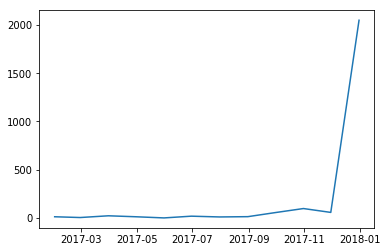

In [210]:
plt.plot(summary.groupby('report_dt').count()['port_no'])

## Merge Lipper_class onto returns data

### Merge does not take dates into account -> TODO

In [211]:
summary.dtypes

port_no                  int64
report_dt       datetime64[ns]
fund_name               object
avrcs                  float64
lipper_class            object
False                   object
cap_class               object
style_class             object
fund_no                  int64
dtype: object

In [212]:
returns.head(1)

,crsp_fundno,caldt,mret,date
168,105.0,2017-01-31,0.028147,2017-01-31


In [213]:
returns_merged = returns.merge(summary, how='left', left_on=['crsp_fundno'],right_on=['fund_no'])
returns_merged.shape

(110059, 13)

In [214]:
returns_merged = returns_merged.drop(columns=['report_dt','fund_no'])

In [215]:
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged.shape

(27103, 11)

#### Take only needed columns and reorder them

In [216]:
returns_merged = returns_merged[['port_no','caldt','mret','lipper_class','style_class','cap_class']]

In [217]:
returns_merged.sample()

,port_no,caldt,mret,lipper_class,style_class,cap_class
104314,1033419.0,2017-10-31,0.007962,MLVE,V,M


## Check for how many funds returns data is available

#### TODO

## Calc mean return per Obj_cd

### Get unique codes for later

In [218]:
group_by = 'lipper_class'

In [219]:
obj_codes = returns_merged[[group_by]].drop_duplicates()
obj_codes = obj_codes[group_by].values
obj_codes

array(['SCCE', 'LCGE', 'LCVE', 'SCGE', 'MCVE', 'LCCE', 'MLVE', 'MLGE',
       'MCCE', 'MLCE', 'SCVE', 'MCGE'], dtype=object)

In [220]:
# Analysis of selected funds
returns_obj = returns_merged.groupby([group_by,'caldt'])['mret'].agg(['mean','count','std'])

In [221]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [222]:
returns_obj['cumret'] = returns_obj.groupby(group_by)[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [223]:
returns_obj_n = returns_obj.pivot_table(
        values='std', 
        index=['caldt'], 
        columns=group_by)

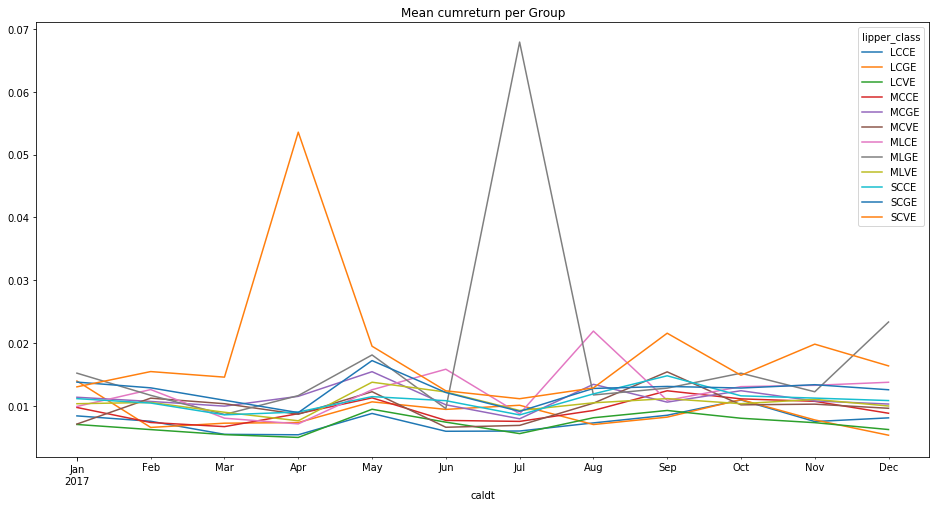

In [224]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Cluster with k-means

#### Metaparameter number of clusters

In [225]:
transformer = MaxAbsScaler().fit(holdings) # fit does nothing.
transformer

MaxAbsScaler(copy=True)

In [226]:
holdings = transformer.transform(holdings)

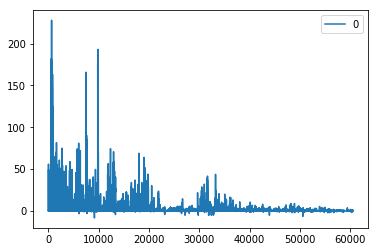

In [227]:
pd.DataFrame(holdings.sum(0)).T.plot()

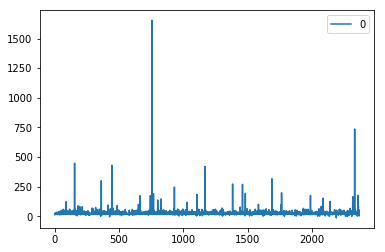

In [228]:
pd.DataFrame(holdings.sum(1)).plot()

In [251]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = 4,
                verbose = True,
                n_init = 5, # Number of runs
                n_jobs= -1,
                random_state=123).fit(holdings[:,:20000])

Start kMeans...
Initialization complete
Iteration  0, inertia 22910.626
Iteration  1, inertia 22109.134
Iteration  2, inertia 21969.537
Iteration  3, inertia 21857.338
Iteration  4, inertia 21816.928
Iteration  5, inertia 21789.796
Iteration  6, inertia 21778.681
Iteration  7, inertia 21773.380
Iteration  8, inertia 21765.799
Iteration  9, inertia 21738.471
Iteration 10, inertia 21673.311
Iteration 11, inertia 21653.074
Iteration 12, inertia 21652.162
Iteration 13, inertia 21651.957
Iteration 14, inertia 21651.924
Iteration 15, inertia 21651.871
Converged at iteration 15: center shift 0.000000e+00 within tolerance 4.681880e-08
Initialization complete
Iteration  0, inertia 26994.193
Iteration  1, inertia 22124.889
Iteration  2, inertia 22092.469
Iteration  3, inertia 22086.983
Iteration  4, inertia 22077.897
Iteration  5, inertia 22051.262
Iteration  6, inertia 21903.643
Iteration  7, inertia 21824.667
Iteration  8, inertia 21805.675
Iteration  9, inertia 21794.308
Iteration 10, inertia

In [252]:
labels = pd.DataFrame(kmeans.labels_)

In [253]:
summary['cluster'] = labels.values

In [254]:
round(pd.crosstab(summary['cap_class'],summary['cluster'], margins = True, normalize = 'all') * 100, 2)

cluster,0,1,2,3,All
cap_class,,,,,
L,29.83,0.00,0.00,1.69,31.52
M,18.86,0.08,0.00,21.65,40.59
S,0.08,0.04,0.21,27.55,27.89
All,48.78,0.13,0.21,50.89,100.00


In [255]:
round(pd.crosstab(summary['style_class'],summary['cluster'], margins = True, normalize = 'all') * 100, 2)

cluster,0,1,2,3,All
style_class,,,,,
C,20.72,0.13,0.04,25.53,46.41
G,16.71,0.00,0.00,17.26,33.97
V,11.35,0.00,0.17,8.10,19.62
All,48.78,0.13,0.21,50.89,100.00


## Chart the returns of the formed clustes

In [242]:
summary.sample()

,port_no,report_dt,fund_name,avrcs,lipper_class,False,cap_class,style_class,fund_no,cluster
99859,1026163,2017-12-31,"Principal Funds, Inc: LargeCap Growth Fund; Cl...",96.197692,LCGE,LCVE,L,G,24862,0


#### Merge new clusters into returns

In [243]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','lipper_class','cluster']]
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,cluster
49902,2017-11-30,31946.0,1022128.0,0.035377,MLGE,0.0


#### Calc mean return per Obj_cd

In [244]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

array([0., 1., 3., 2.])

In [245]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [246]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Analysing clusters

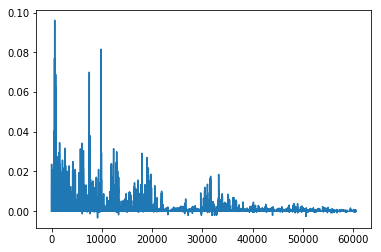

In [247]:
plt.plot(kmeans.cluster_centers_[0,:])

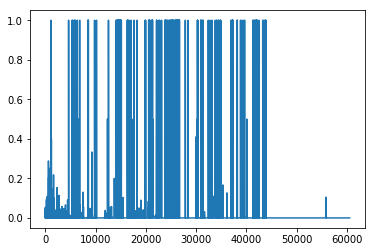

In [248]:
plt.plot(kmeans.cluster_centers_[1,:])

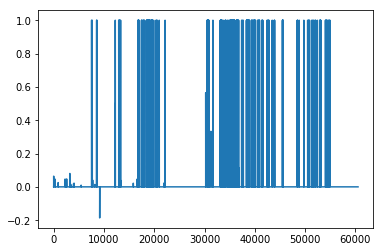

In [249]:
plt.plot(kmeans.cluster_centers_[2,:])

## PCA

In [ ]:
pca = PCA(n_components=10)
pca.fit(holdings.toarray())  

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

In [ ]:
df = pd.DataFrame(pca.components_).T
df = pd.DataFrame({
    'pca_1' : df.iloc[:,0],
    'pca_2' : df.iloc[:,1],
    'labels' : labels.iloc[:,0]
})

In [ ]:
df.plot.scatter(x='pca_1',
                y='pca_2',
                c='labels',
                colormap='viridis')

# Visualize

In [ ]:
MiniBatchKMeans?

For n_clusters = 2 The average silhouette_score is : 0.6655655253020518
For n_clusters = 3 The average silhouette_score is : -0.11048678935719358
For n_clusters = 4 The average silhouette_score is : -0.11397895334543343
For n_clusters = 5 The average silhouette_score is : -0.1770654711818058


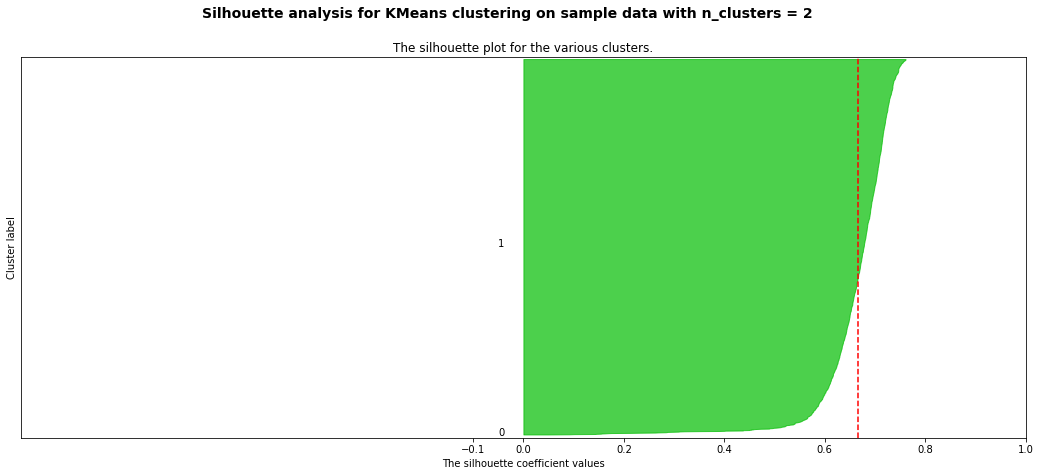

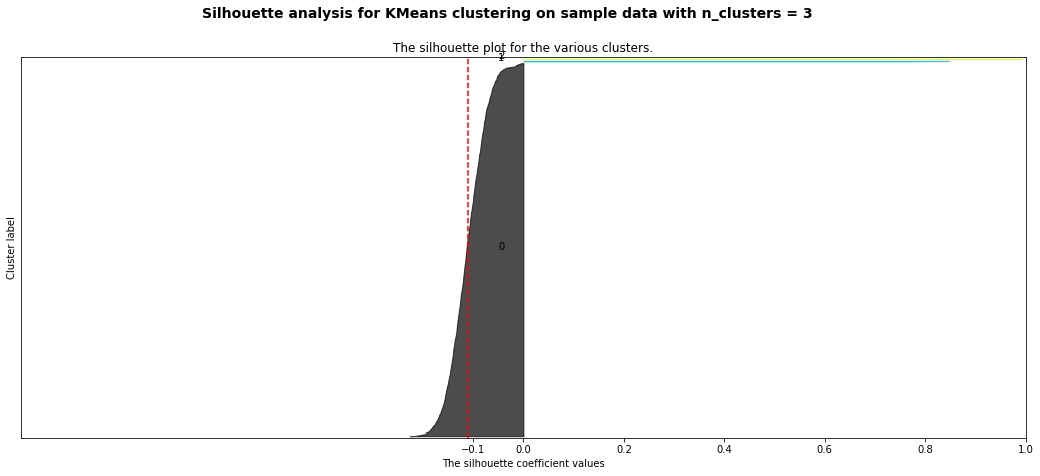

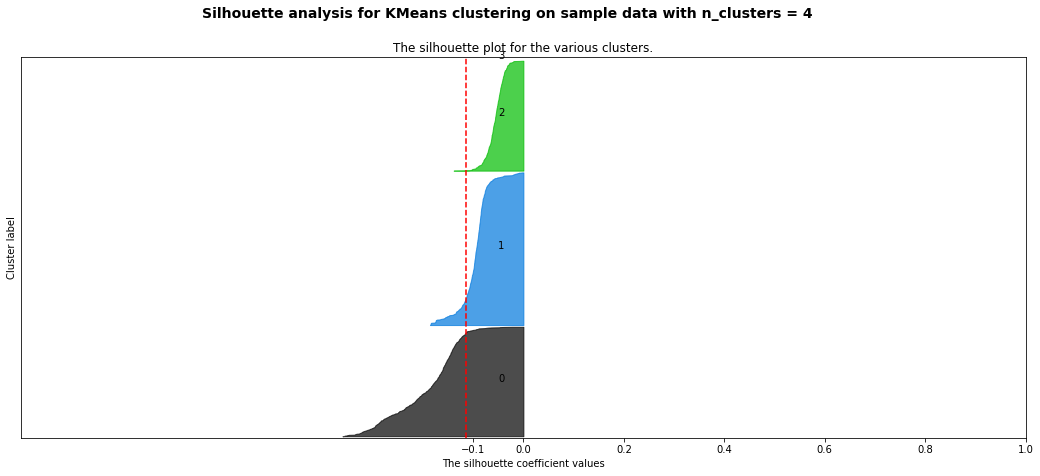

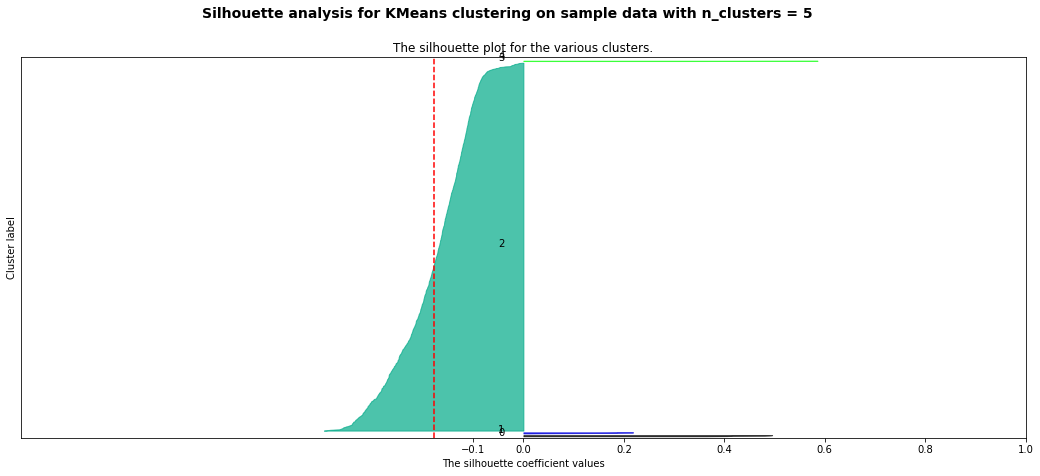

In [250]:
### Based on example code from sklearn ###

X = holdings
n_clusters = [2,3,4,5]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(holdings)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()